In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import time
import unicodedata

from selenium import webdriver
from selenium.webdriver.chrome.options import Options  

In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
datetime.now()

datetime.datetime(2020, 6, 18, 9, 9, 39, 26092)

In [4]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'


driver.get(url)



In [5]:
content = driver.page_source

In [6]:
date_time_str = re.search('(\d+ \w+ 202\d)' ,str(content)).group(1)
date_time_str

'17 June 2020'

In [7]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-06-17'

### Dataframe

In [8]:
for i in range(40): # retry and wait till the tables are loaded
    try:
        dfs = pd.read_html(driver.page_source)
        if len(dfs)>0:
            break
    except ValueError as e:
        print(e)
    time.sleep(1)
dfs

No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found


[  Jurisdiction Unnamed: 1  Total confirmed cases  New cases in last 24 hours  \
 0    Australia  Australia                   7370                          23   
 1          ACT        ACT                    108                           0   
 2          NSW        NSW                   3135                           1   
 3           NT         NT                     29                           0   
 4          QLD        QLD                   1066                           1   
 5           SA         SA                    440                           0   
 6          TAS        TAS                    228                           0   
 7          VIC        VIC                   1762                          21   
 8           WA         WA                    602                           0   
 
    Deaths  Unnamed: 5  
 0     102         NaN  
 1       3         NaN  
 2      48         NaN  
 3       0         NaN  
 4       6         NaN  
 5       4         NaN  
 6      13   

In [9]:
df = dfs[0]
df = df.iloc[:,1:3].T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df

Unnamed: 1,Australia,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Total confirmed cases,7370,108,3135,29,1066,440,228,1762,602


In [10]:


df.insert(0, 'date', data_date_time)
df = df.rename(columns={
    'Australia':'australia',
    'ACT':'act',
    'NSW':'nsw',
    'QLD':'qld',
    'SA':'sa',
    'TAS':'tas',
    'VIC':'victoria',
    'WA':'wa',
    'NT':'nt',
})
df

Unnamed: 1,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-06-17,7370,108,3135,29,1066,440,228,1762,602


In [11]:
assert int(df['australia'])>0

In [12]:
df

Unnamed: 1,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-06-17,7370,108,3135,29,1066,440,228,1762,602


### Save to file

In [13]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

,act,australia,date,nsw,nt,qld,sa,tas,victoria,wa
0,NaN,12,2020-02-04,4,NaN,2,2,NaN,4,NaN
1,NaN,13,2020-02-05,4,NaN,3,2,NaN,4,NaN
2,NaN,14,2020-02-06,4,NaN,4,2,NaN,4,NaN
3,NaN,15,2020-02-07,4,NaN,5,2,NaN,4,NaN
4,NaN,15,2020-02-08,4,NaN,5,2,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...
129,108,7302,2020-06-13,3119,29,1065,440,228,1711,602
130,108,7320,2020-06-14,3128,29,1065,440,228,1720,602
131,108,7335,2020-06-15,3131,29,1065,440,228,1732,602
132,108,7347,2020-06-16,3134,29,1065,440,228,1741,602


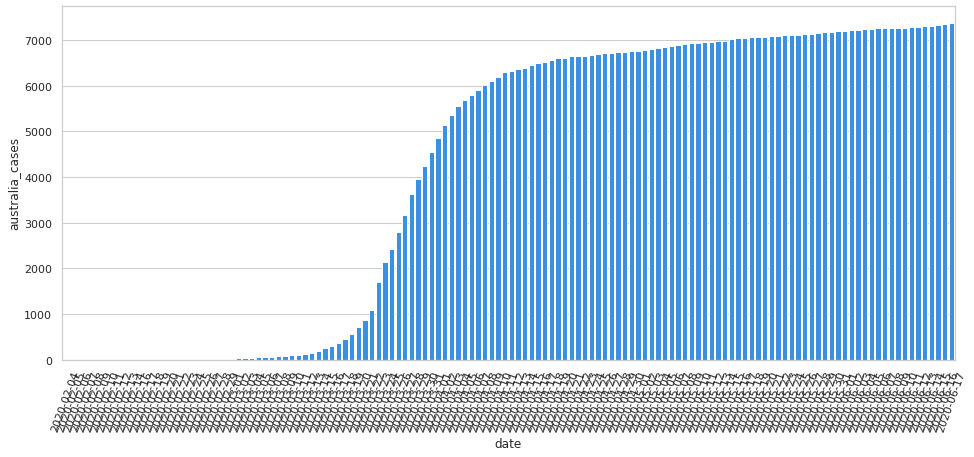

In [15]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [16]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
